# Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Switching to GPU

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Data Preprocessing

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Getting the data

In [ ]:
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 43.6MB/s]


# Dividing data into batches

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle= True)
test_loader = DataLoader(test_data, batch_size=64, shuffle = True)

# Building Model

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)  # BatchNorm after Conv1
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)  # BatchNorm after Conv2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)  # BatchNorm after Conv2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # LazyLinear will infer input features automatically during first forward pass
        self.fc1 = nn.LazyLinear(128)
        self.drop1 = nn.Dropout(0.3)
        self.fc2 = nn.LazyLinear(128)
        self.drop2 = nn.Dropout(0.3)
        self.fc3 = nn.LazyLinear(128)
        self.drop3 = nn.Dropout(0.3)
        self.out = nn.Linear(128, 10)  # Final output layer for 10 classes (CIFAR-10)

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = torch.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        x = x.flatten(1)  # Flatten before fully connected layers

        x = torch.relu(self.fc1(x))
        x = self.drop1(x)  # Apply Dropout

        x = torch.relu(self.fc2(x))
        x = self.drop2(x)  # Apply Dropout

        x = torch.relu(self.fc3(x))
        x = self.drop3(x)  # Apply Dropout

        x = self.out(x)  # No activation here (logits)
        return x

# Model Initialization
model = Model().to(device)
print(model)


Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=128, bias=True)
  (drop1): Dropout(p=0.3, inplace=False)
  (fc2): LazyLinear(in_features=0, out_features=128, bias=True)
  (drop2): Dropout(p=0.3, inplace=False)
  (fc3): LazyLinear(in_fea

# Createing loss function and optimization function

In [ ]:
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training our Data

In [ ]:
train_losses = []
train_accuracies = []

epochs = 70  # or however many you choose

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    model.train()

    for images, labels in train_loader:
        optimizer.zero_grad()
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = loss_fun(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy on the fly for this batch
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = 100 * correct / total

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # scheduler.step()  # if you're using a scheduler

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")



Epoch [1/70], Loss: 1.4985, Accuracy: 44.51%
Epoch [2/70], Loss: 1.1536, Accuracy: 59.69%
Epoch [3/70], Loss: 1.0229, Accuracy: 64.88%
Epoch [4/70], Loss: 0.9427, Accuracy: 67.92%
Epoch [5/70], Loss: 0.8697, Accuracy: 70.69%
Epoch [6/70], Loss: 0.8296, Accuracy: 72.26%
Epoch [7/70], Loss: 0.7949, Accuracy: 73.53%
Epoch [8/70], Loss: 0.7563, Accuracy: 74.66%
Epoch [9/70], Loss: 0.7291, Accuracy: 75.76%
Epoch [10/70], Loss: 0.7048, Accuracy: 76.72%
Epoch [11/70], Loss: 0.6814, Accuracy: 77.43%
Epoch [12/70], Loss: 0.6626, Accuracy: 78.03%
Epoch [13/70], Loss: 0.6359, Accuracy: 78.97%
Epoch [14/70], Loss: 0.6171, Accuracy: 79.75%
Epoch [15/70], Loss: 0.6089, Accuracy: 80.17%
Epoch [16/70], Loss: 0.5889, Accuracy: 80.57%
Epoch [17/70], Loss: 0.5748, Accuracy: 80.80%
Epoch [18/70], Loss: 0.5589, Accuracy: 81.57%
Epoch [19/70], Loss: 0.5437, Accuracy: 82.02%
Epoch [20/70], Loss: 0.5333, Accuracy: 82.43%
Epoch [21/70], Loss: 0.5217, Accuracy: 82.83%
Epoch [22/70], Loss: 0.5132, Accuracy: 83.0

# Plotting Curve

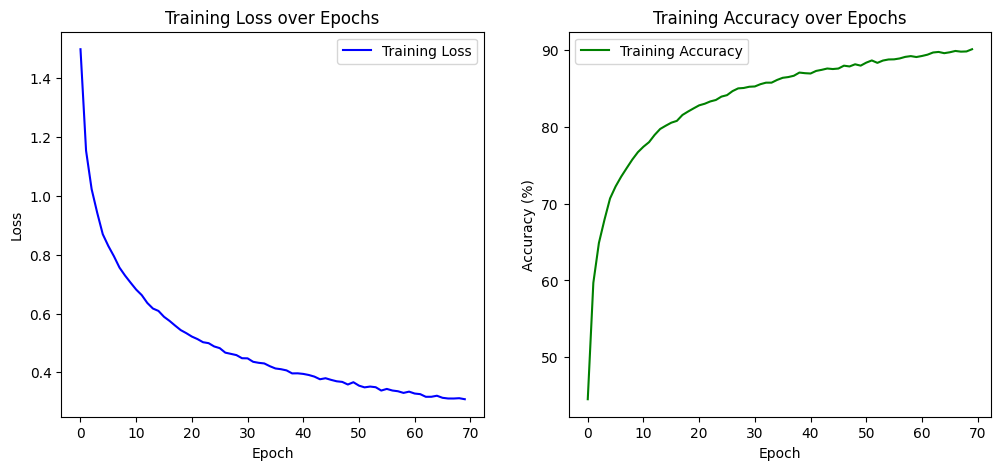

In [ ]:
import matplotlib.pyplot as plt

# Plot Training Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy over Epochs')
plt.legend()

plt.show()


# Evaluating our Model

In [ ]:
model.eval()

correct = 0
total = 0

with torch.no_grad():
  for images, labels in (test_loader):
    images, labels = images.to(device), labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 81.56%
